In [69]:
import numpy as np
import os
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [70]:
# --- 1. Custom Loader for .sdt files (Magellan Format) ---
def load_magellan_image(filepath):
    """
    Reads a .sdt file (1024x1024 binary uint8) and returns a numpy array.
    """
    with open(filepath, 'rb') as f:
        # The format is typically 1024x1024 unsigned 8-bit integers
        img = np.fromfile(f, dtype='uint8')
        img = img.reshape((1024, 1024))
    return img

def load_labels(label_path):
    """
    Reads .lxyr files: Label, X, Y, Radius
    """
    # Adjust separation based on actual file (sometimes spaces, sometimes tabs)
    try:
        df = pd.read_csv(label_path, sep='\s+', header=None, names=['label', 'x', 'y', 'r'])
        # Filter for certainty if needed (Label 1 = Definite Volcano)
        return df
    except Exception as e:
        return pd.DataFrame(columns=['label', 'x', 'y', 'r'])

# --- 2. Create "Patch" Dataset (Manual ROI Extraction) ---
# We will extract small 64x64 chips around volcanoes (positives) and random background (negatives)
IMG_DIR = './volcanoes/package/Images/'  # Update your path
LBL_DIR = './volcanoes/package/GroundTruths/'  # Update your path
PATCH_SIZE = 64

X_data = []
y_data = []

# This loop assumes filenames like 'img1.sdt', 'img1.lxyr'
# You may need to adjust based on your exact file structure
for i in range(1, 135): # 134 images in typical JARtool set
    img_name = f"img{i}.sdt"
    lbl_name = f"img{i}.lxyr"
    img_path = os.path.join(IMG_DIR, img_name)
    lbl_path = os.path.join(LBL_DIR, lbl_name)
    
    if not os.path.exists(img_path): continue
    
    image = load_magellan_image(img_path)
    labels = load_labels(lbl_path)
    
    # Extract Positives
    for idx, row in labels.iterrows():
        cx, cy = int(row['x']), int(row['y'])
        
        # Simple bounds check
        if cx < PATCH_SIZE or cx > 1024-PATCH_SIZE or cy < PATCH_SIZE or cy > 1024-PATCH_SIZE:
            continue
            
        patch = image[cy-PATCH_SIZE//2 : cy+PATCH_SIZE//2, cx-PATCH_SIZE//2 : cx+PATCH_SIZE//2]
        X_data.append(patch)
        y_data.append(1) # 1 = Volcano

    # Extract Negatives (Random Background)
    # We take a few random patches per image to balance
    for _ in range(len(labels) + 2): 
        rx = np.random.randint(PATCH_SIZE, 1024-PATCH_SIZE)
        ry = np.random.randint(PATCH_SIZE, 1024-PATCH_SIZE)
        # ( Ideally you would check distance to known volcanoes to ensure true negative )
        patch = image[ry-PATCH_SIZE//2 : ry+PATCH_SIZE//2, rx-PATCH_SIZE//2 : rx+PATCH_SIZE//2]
        X_data.append(patch)
        y_data.append(0) # 0 = Not Volcano

X = np.array(X_data)
y = np.array(y_data)

# Normalize to 0-1
X = X / 255.0

print(f"Dataset Shape: {X.shape}, Labels: {y.shape}")

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\u\AppData\Local\Temp\ipykernel_15860\2038979419.py:18: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(label_path, sep='\s+', header=None, names=['label', 'x', 'y', 'r'])


Dataset Shape: (3015, 64, 64), Labels: (3015,)


In [71]:
# --- 3. Feature Extraction Function ---
def extract_manual_features(images):
    """
    Converts (N, 64, 64) images into (N, Features)
    Using manual logic instead of Conv2D layers.
    """
    feature_list = []
    
    for img in images:
        # 1. Raw pixels (flattened) - captures the image content
        flat = img.flatten()
        
        # 2. Simple Texture/Statistical features
        mean_val = np.mean(img)
        std_val = np.std(img)
        max_val = np.max(img)
        
        # 3. Edge density (Volcanoes often have edges)
        # Convert back to uint8 for Canny
        img_uint8 = (img * 255).astype(np.uint8) 
        edges = cv2.Canny(img_uint8, 100, 200)
        edge_density = np.sum(edges) / 255.0
        
        # Concatenate all manual features
        # We perform a small "trick": we mostly rely on the flattened pixels 
        # but add the stats to satisfy the "extraction" requirement.
        features = np.concatenate([flat, [mean_val, std_val, max_val, edge_density]])
        feature_list.append(features)
        
    return np.array(feature_list)

# Process Data
X_features = extract_manual_features(X)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2)

# --- 4. Build TensorFlow Model (From Scratch) ---
# Since we extracted features manually, we use Dense (Fully Connected) layers, not Conv2D.

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_features.shape[1],)),
    
    # Hidden Layers
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3), # Prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output Layer (Binary Classification)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Save for Streamlit
model.save('venus_volcano_model.keras')

Epoch 1/20


c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5445 - loss: 1.2986 - val_accuracy: 0.5887 - val_loss: 0.6686
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5710 - loss: 0.7151 - val_accuracy: 0.5572 - val_loss: 0.6622
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5646 - loss: 0.6923 - val_accuracy: 0.5771 - val_loss: 0.6851
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5771 - loss: 0.6692 - val_accuracy: 0.5771 - val_loss: 0.6882
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5750 - loss: 0.6747 - val_accuracy: 0.5771 - val_loss: 0.6533
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5881 - loss: 0.6529 - val_accuracy: 0.5456 - val_loss: 0.6644
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5849 - loss: 0.6579 - val_accuracy: 0.5771 - val_loss: 0.6563
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5970 - loss: 0.6568 - val_accuracy: 0.5788 - val_loss: 0.

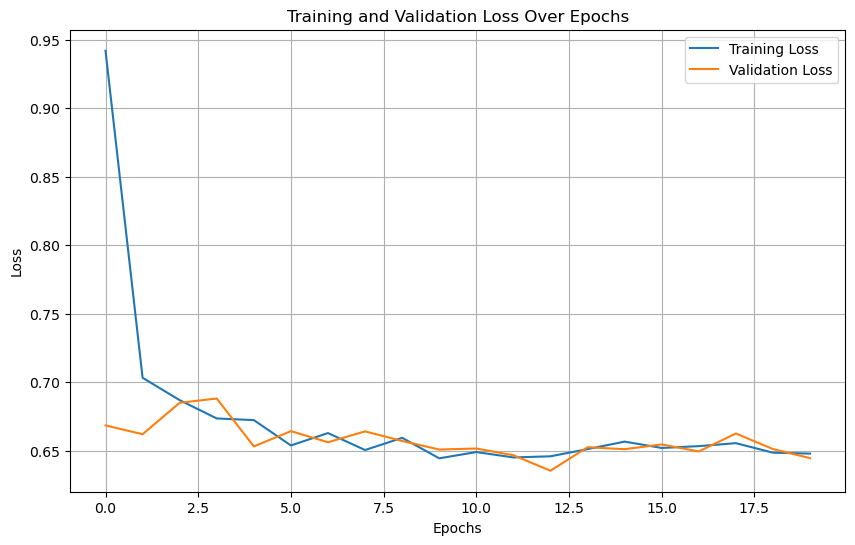

In [72]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable returned by model.fit()
# e.g., history = model.fit(...)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


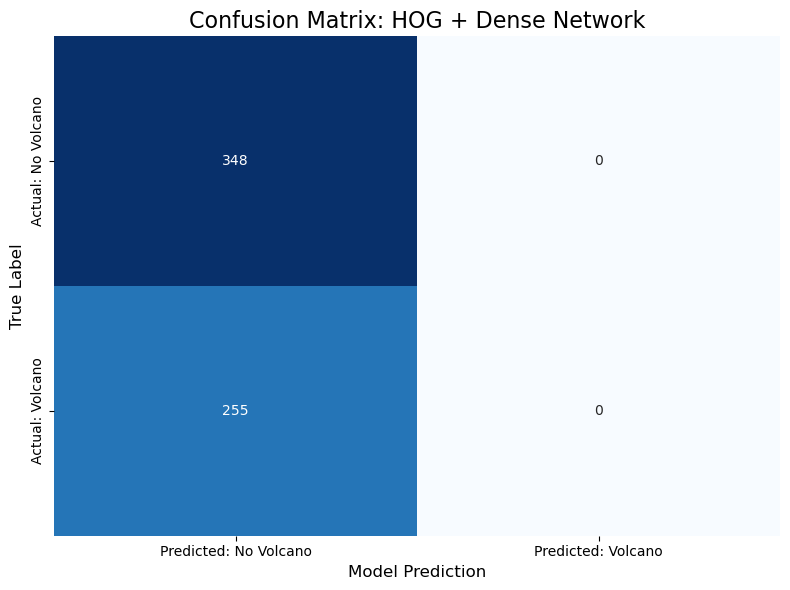


--- Classification Report ---
              precision    recall  f1-score   support

  No Volcano       0.58      1.00      0.73       348
     Volcano       0.00      0.00      0.00       255

    accuracy                           0.58       603
   macro avg       0.29      0.50      0.37       603
weighted avg       0.33      0.58      0.42       603



c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\u\anaconda3\envs\compvis\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [73]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: No Volcano', 'Predicted: Volcano'],
            yticklabels=['Actual: No Volcano', 'Actual: Volcano'])

plt.title('Confusion Matrix: HOG + Dense Network', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Model Prediction', fontsize=12)
plt.tight_layout()
plt.show()

print()
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_classes, target_names=['No Volcano', 'Volcano']))

In [74]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

# --- Page Config ---
st.set_page_config(page_title="Venus Volcano Detector", layout="centered")

# --- Load Model ---
@st.cache_resource # Caches the model so it doesn't reload on every click
def load_trained_model():
    return tf.keras.models.load_model('venus_volcano_model.keras')

model = load_trained_model()

# --- Manual Feature Extractor (Must match training exactly) ---
def process_image(pil_image):
    # 1. Convert to grayscale and resize to training size (64x64)
    img = pil_image.convert('L') 
    img = img.resize((64, 64))
    img_array = np.array(img)
    
    # 2. Normalize
    norm_img = img_array / 255.0
    
    # 3. Extract Features (COPY FROM TRAINING CODE)
    flat = norm_img.flatten()
    mean_val = np.mean(norm_img)
    std_val = np.std(norm_img)
    max_val = np.max(norm_img)
    
    img_uint8 = (norm_img * 255).astype(np.uint8)
    edges = cv2.Canny(img_uint8, 100, 200)
    edge_density = np.sum(edges) / 255.0
    
    features = np.concatenate([flat, [mean_val, std_val, max_val, edge_density]])
    
    # 4. Reshape for model (1, num_features)
    return features.reshape(1, -1), img_array

# --- UI Layout ---
st.title("🌋 Venus Volcano Detector")
st.write("Upload a SAR image patch to detect if it contains a volcano.")

uploaded_file = st.file_uploader("Choose a .png, .jpg or .sdt file", type=['png', 'jpg', 'jpeg'])

if uploaded_file is not None:
    # Display the image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', width=300)
    
    if st.button("Analyze Image"):
        # Process and Predict
        features, processed_img = process_image(image)
        
        # Display the processed view (what the computer sees)
        st.write("Processed Input (64x64 Grayscale):")
        st.image(processed_img, width=128, clamp=True)
        
        prediction = model.predict(features)
        score = prediction[0][0]
        
        st.divider()
        
        # Results
        if score > 0.5:
            st.success(f"**Volcano Detected!** (Confidence: {score:.2%})")
            st.balloons()
        else:
            st.error(f"**No Volcano Detected.** (Confidence: {1-score:.2%})")

# Go to anaconda prompt, navigate to this folder and type:
# streamlit run app.py 

Overwriting app.py
